## Setup an IBM account

In [4]:
### Create an account on https://quantum-computing.ibm.com/login
### Copy the API token from the homepage once logged in.
token = '4c009ac74d75aae40b28b1c22af444fc6da3730bb13b4735263cb69cff1535ec999e9a604e60eaa0b0c6953428e83d2119040d18ff3a81a345e0f44c6a17f460'

## Install the required packages

In [9]:
!pip install -U -r requirements.txt
from IPython.display import clear_output
clear_output()

In [10]:
import qiskit
import numpy
import matplotlib
import qiskit_ibm_provider
print("Qiskit version:", qiskit.__version__)
print("NumPy version:", numpy.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("provider version:", qiskit_ibm_provider.__version__)


Qiskit version: 0.45.0
NumPy version: 1.23.5
Matplotlib version: 3.8.1
provider version: 0.7.2


In [13]:
from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.visualization import plot_gate_map, timeline_drawer
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from qiskit_ibm_provider import IBMProvider
IBMProvider.save_account(token=token, overwrite=True)
# IBMProvider.saved_accounts()

In [14]:
provider = IBMProvider()
backends = provider.backends()
backends

[<IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibm_brisbane')>]

In [15]:
backend = provider.get_backend('ibm_lagos')

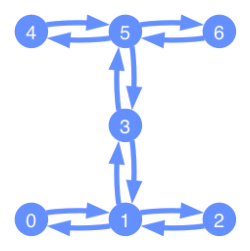

In [16]:
plot_gate_map(backend, figsize=(3,3),qubit_size = 30, font_size = 15, plot_directed=True)

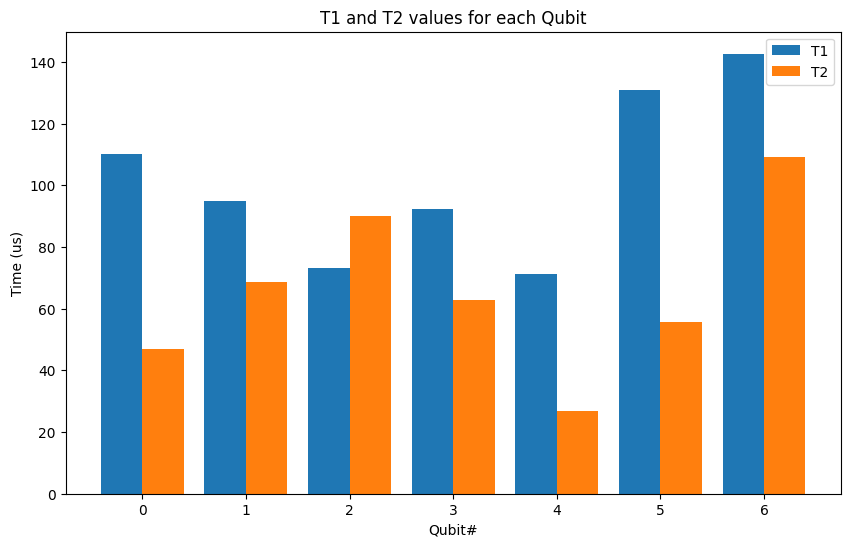

In [17]:
properties = backend.properties()

# Extract T1 and T2 times
# Extract data from the properties
t1s = [qubit_data[0].value for qubit_data in properties.qubits]
t2s = [qubit_data[1].value for qubit_data in properties.qubits]
readout_errors = [qubit_data[4].value for qubit_data in properties.qubits]

import matplotlib.pyplot as plt

qubit_indices = [i for i, _ in enumerate(t1s)]

plt.figure(figsize=(10,6))
plt.bar(qubit_indices, t1s, width=-0.4, align='edge', label='T1')
plt.bar(qubit_indices, t2s, width=0.4, align='edge', label='T2')
plt.xlabel('Qubit#')
plt.ylabel('Time (us)')  # Changed to microseconds based on your sample
plt.title('T1 and T2 values for each Qubit')
plt.legend()
plt.show()


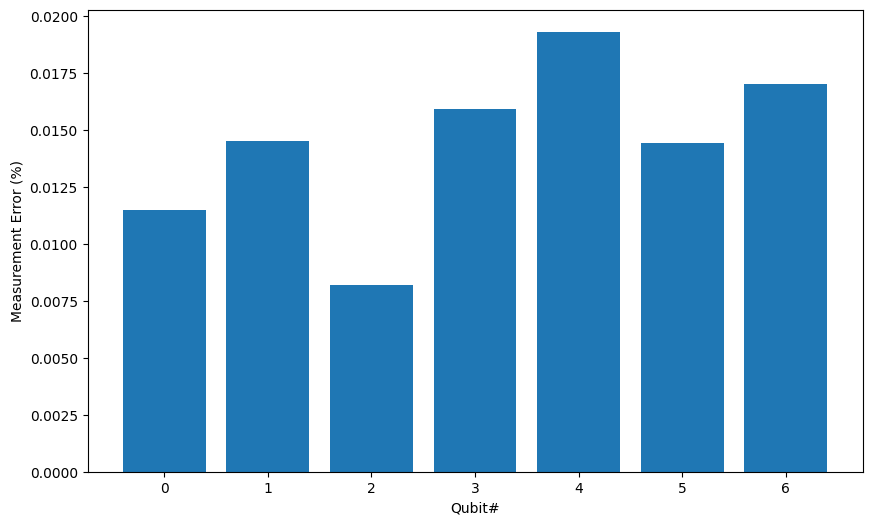

In [18]:
plt.figure(figsize=(10,6))
plt.bar(qubit_indices, readout_errors, align='center', label='Readout Error')
plt.xlabel('Qubit#')
plt.ylabel('Measurement Error (%)')
plt.show()

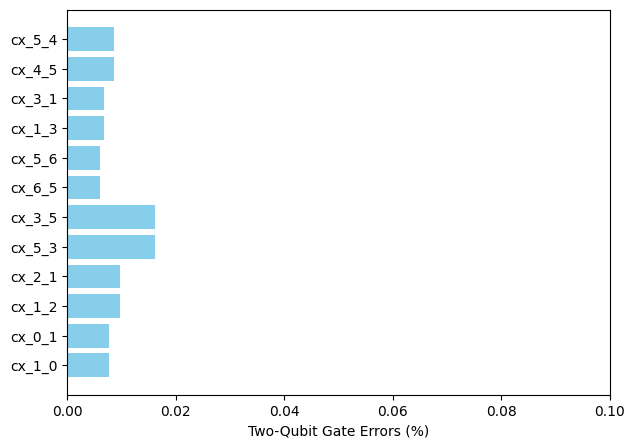

In [19]:
two_qubit_gate_errors = []

for gate in properties.gates:
    if gate.gate == 'cx':
        gate_error = next((item.value for item in gate.parameters if item.name == 'gate_error'), None)
        if gate_error:
            two_qubit_gate_errors.append((gate.qubits, gate_error))

# Extract data for plotting
gate_names = [f"cx_{gate[0][0]}_{gate[0][1]}" for gate in two_qubit_gate_errors]
errors = [gate[1] for gate in two_qubit_gate_errors]

# Plot
plt.figure(figsize=(7,5)) 
plt.barh(gate_names, errors, align='center', color='skyblue')
plt.xlabel('Two-Qubit Gate Errors (%)')
plt.xlim(0,0.1)
plt.gca().invert_yaxis()  # to display the top qubit pairs at the top
plt.show()

## Generating a GHZ circuit

In [20]:
def GHZ_prep(n):
    circuits = []
    qc = QuantumCircuit(n,n)
    mid = int(n/2)
    qc.h(mid)
    for i in range(mid):
        qc.cx(mid-i,mid-i-1)
        if mid+i+1<n:
            qc.cx(mid+i,mid+i+1)
    qc.barrier()
    qc.measure(range(n),range(n))
    return qc

In [21]:
GHZ_ckts = [GHZ_prep(n) for n in range(2,6)]
GHZ_ckts

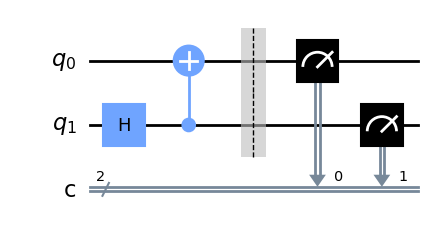

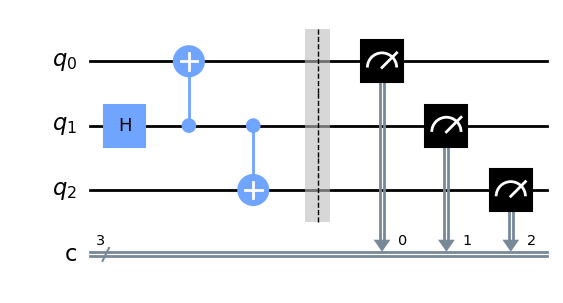

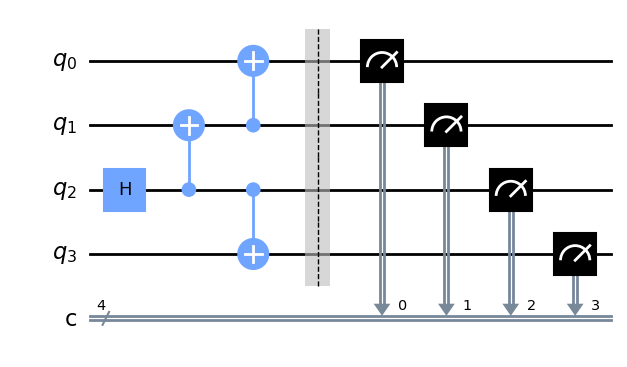

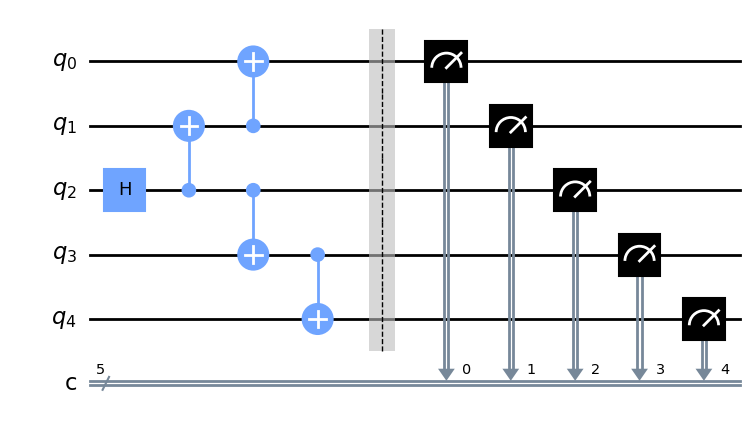

In [22]:
for i in range(len(GHZ_ckts)):
    display(GHZ_ckts[i].draw('mpl', style="clifford"))

In [23]:
def GHZ_prep_with_inverse(n):
    circuits = []
    qc = QuantumCircuit(n, n)
    mid = int(n / 2)
    
    # GHZ State Preparation
    qc.h(mid)
    for i in range(mid):
        qc.cx(mid - i, mid - i - 1)
        if mid + i + 1 < n:
            qc.cx(mid + i, mid + i + 1)
    qc.barrier()
    # Inverse GHZ State Preparation
    for i in reversed(range(mid)):
        if mid + i + 1 < n:
            qc.cx(mid + i, mid + i + 1)
        qc.cx(mid - i, mid - i - 1)
    qc.h(mid)
    qc.barrier()
    # Measurement
    qc.measure(range(n), range(n))
    return qc

In [24]:
GHZ_ckts2 = [GHZ_prep_with_inverse(n) for n in range(2,6)]
GHZ_ckts2

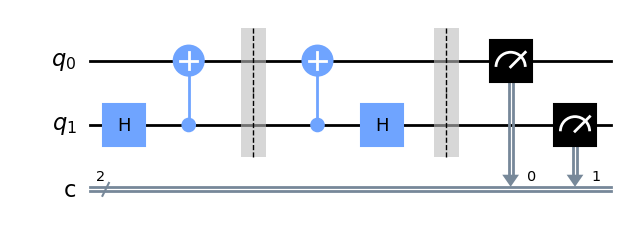

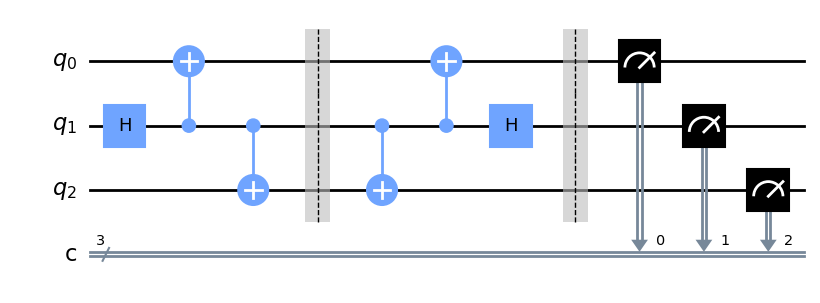

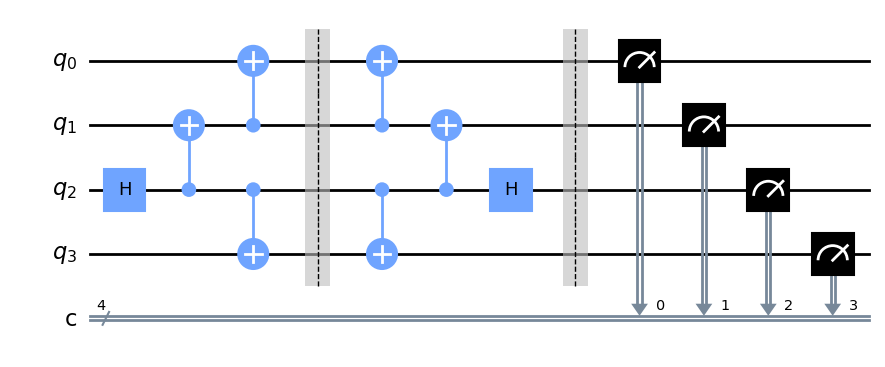

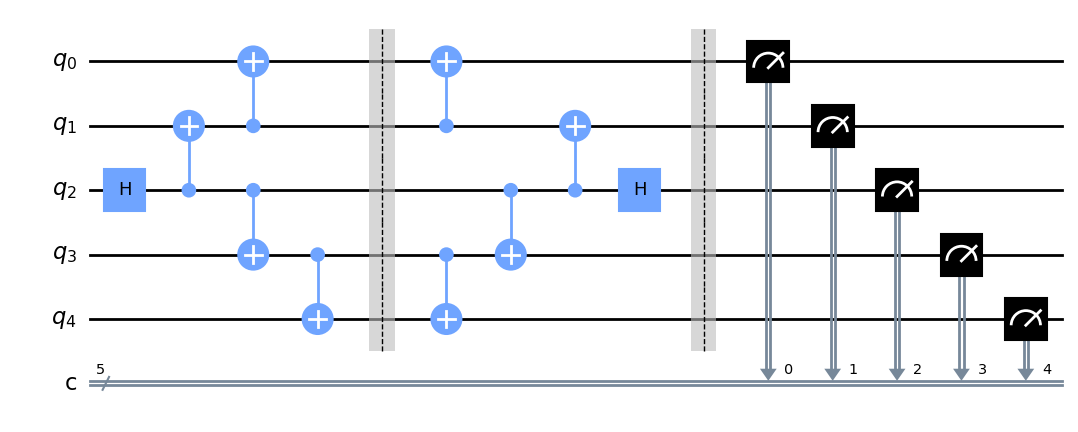

In [25]:
from IPython.display import display

for i in range(len(GHZ_ckts2)):
    display(GHZ_ckts2[i].draw('mpl', style="clifford"))

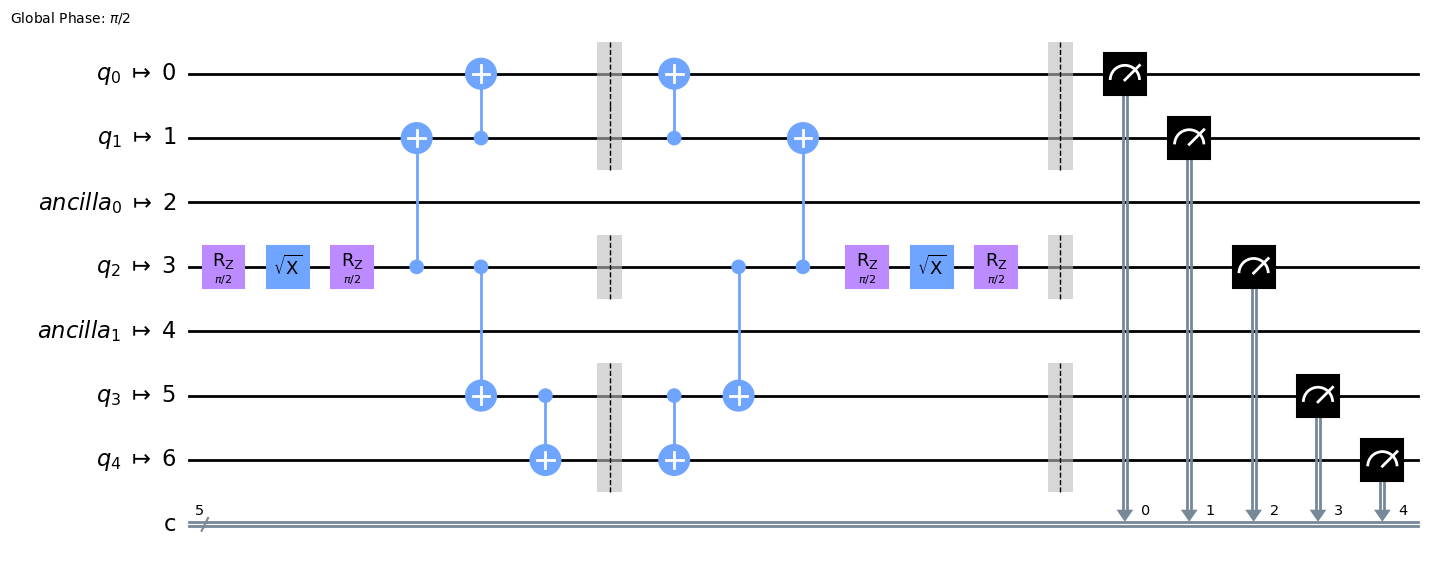

In [26]:
layout = [0,1,3,5,6]
GHZ_5 = GHZ_prep_with_inverse(5)
GHZ_ckts_transpiled = transpile(GHZ_5, backend, initial_layout=layout, optimization_level=0)
GHZ_ckts_transpiled.draw('mpl',style="clifford")

## Adding DD

In [27]:
from qiskit_ibm_provider.transpiler.passes.scheduling import DynamicCircuitInstructionDurations
from qiskit_ibm_provider.transpiler.passes.scheduling import ALAPScheduleAnalysis

from qiskit.circuit.library import XGate, RZGate
from qiskit_ibm_provider.transpiler.passes.scheduling import PadDynamicalDecoupling as PDDDynamic
from qiskit.transpiler import PassManager 

dd_sequence_2 = [XGate(), XGate()]
dd_sequence_4 = [XGate(), XGate(),XGate(), XGate()]

durations = DynamicCircuitInstructionDurations.from_backend(backend)

pm_dynamic_2X = PassManager(
    [
        ALAPScheduleAnalysis(durations),
        PDDDynamic(durations, dd_sequence_2, spacings = [1/4, 1/2, 1/4], 
                sequence_min_length_ratios =[2], extra_slack_distribution='edges'),
    ])

pm_dynamic_4X = PassManager(
                    [
                        ALAPScheduleAnalysis(durations),
                        PDDDynamic(durations, dd_sequence_4, spacings = [1/8, 1/4, 1/4, 1/4, 1/8], 
                                sequence_min_length_ratios =[1], extra_slack_distribution='edges'),
                    ])


In [28]:
circuit_dd_2X = pm_dynamic_2X.run(GHZ_ckts_transpiled)
circuit_dd_4X = pm_dynamic_4X.run(GHZ_ckts_transpiled)

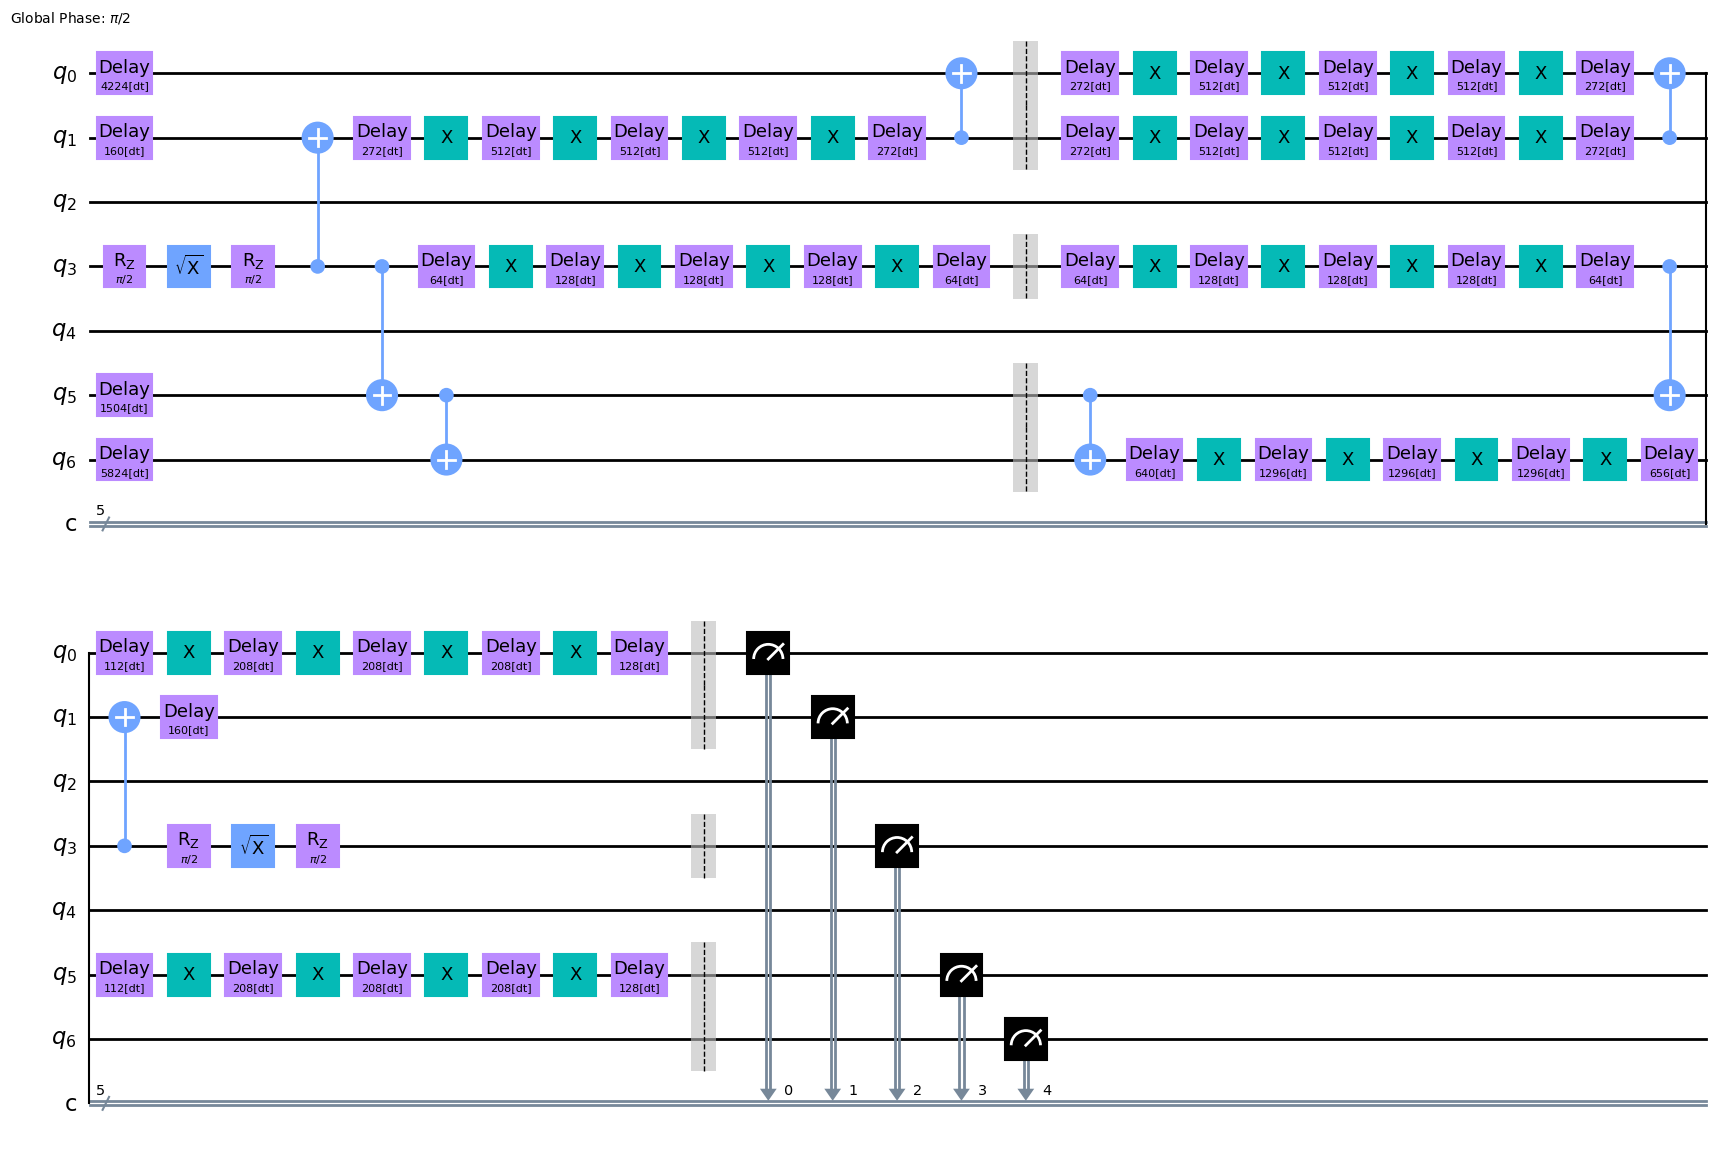

In [29]:
circuit_dd_4X.draw('mpl', style="clifford")

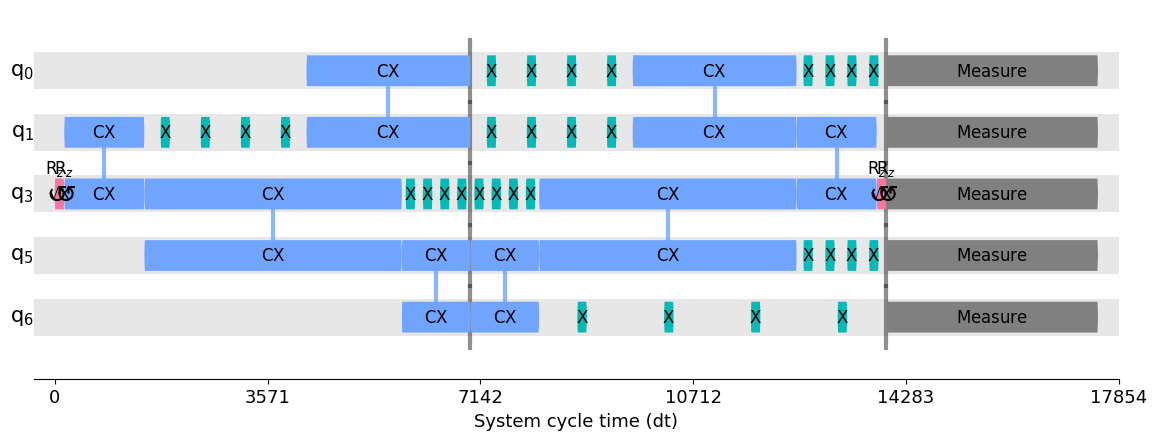

In [30]:
ckt_sched = transpile(circuit_dd_4X, backend=backend, scheduling_method='alap',  routing_method=None)
timeline_drawer(ckt_sched, show_idle=False)

## Running the experiments on real quantum processor

In [32]:
shots = 4000
all_ckts = [GHZ_ckts_transpiled, circuit_dd_2X, circuit_dd_4X]
job = backend.run(all_ckts, shots=shots)

In [37]:
job.status()

<JobStatus.QUEUED: 'job is queued'>

In [33]:
print(job.job_id())

cna04h28ff30008rjfkg


'cn99vd5n6vt000847y30'

In [34]:
job_id = 'cn99vd5n6vt000847y30'

## loading the job and looking at the results

In [35]:
job_reloaded = provider.backend.retrieve_job(job_id)

In [38]:
job_reloaded.status()

<JobStatus.DONE: 'job has successfully run'>

In [39]:
result = job_reloaded.result()
counts = result.get_counts()

In [40]:
len(counts)

3

In [18]:
counts[0]['00000']/ sum(counts[0].values()) ## No DD

0.72525

In [42]:
counts[1]['00000']/ sum(counts[1].values()) ## X2 DD

0.828

In [43]:
counts[2]['00000']/ sum(counts[2].values()) ## X4 DD

0.82375